In [1]:
"""
Identify wildfire events with >= 1% pre-fire aspen forest cover across western U.S. ecoregions

Data sources
    - Wildfire perimeters: NIFC Interagency Final Wildfire Perimeters
    - Landcover: LANDFIRE Existing Vegetation Type (EVT) ca. 2016
    
Author: maxwell.cook@colorado.edu
"""

import os, sys, time, gc
import geopandas as gpd
import rioxarray as rxr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Join to western U.S. ecoregions

In [3]:
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

In [4]:
# Load the NIFC perimeters
fp = os.path.join(projdir,'data/spatial/raw/NIFC/nifc-interagency_2018_to_2023.gpkg')
events = gpd.read_file(fp)
print(f"There are [{len(events)}] NIFC perimeters.\n{events.columns}")

There are [18294] NIFC perimeters.
Index(['OBJECTID', 'MAP_METHOD', 'DATE_CUR', 'COMMENTS', 'GEO_ID', 'IRWINID',
       'UNQE_FIRE_', 'FIRE_YEAR', 'LOCAL_NUM', 'INCIDENT', 'UNIT_ID',
       'POO_RESP_I', 'FEATURE_CA', 'GIS_ACRES', 'USER_NAME', 'SOURCE',
       'AGENCY', 'FIRE_YEAR_', 'Shape__Are', 'Shape__Len', 'FORID', 'OTHERID',
       'geometry'],
      dtype='object')


In [5]:
# Tidy the columns.
events = events[['OBJECTID','MAP_METHOD','GEO_ID','IRWINID','FIRE_YEAR',
                 'INCIDENT','FEATURE_CA','GIS_ACRES','geometry']]
events.head(3)

,OBJECTID,MAP_METHOD,GEO_ID,IRWINID,FIRE_YEAR,INCIDENT,FEATURE_CA,GIS_ACRES,geometry
0,6,Digitized-Other,{FA48870F-92E7-4828-8F17-048DEFEFFE55},{49CC991F-B18D-4DD9-9B4B-864926555272},2018,DEVIL CREEK,Wildfire Final Fire Perimeter,20.46,"MULTIPOLYGON (((-981734.624 1646309.303, -9816..."
1,7,GPS - Differentially Corrected Data,{EDE06BB7-1887-4BED-854B-7574B4F50014},{88801A69-B042-40CA-9011-FAA3C4A12B56},2021,COLT,Wildfire Final Fire Perimeter,30.42,"MULTIPOLYGON (((-1085995.637 1681954.845, -108..."
2,8,Digitized-Other,{F20E18C7-90A3-41DD-99EA-C1F56FA21FEC},{5918038B-F5F3-4C9F-8616-EE1F92817EB5},2019,577,Wildfire Final Fire Perimeter,89.31,"MULTIPOLYGON (((-1003963.720 1628464.675, -100..."


In [6]:
# Check on the burned area distribution
events['GIS_ACRES'].describe()

count    1.829400e+04
mean     1.049767e+05
std      1.342460e+06
min      0.000000e+00
25%      2.512500e+00
50%      2.470500e+01
75%      2.262275e+02
max      1.314430e+08
Name: GIS_ACRES, dtype: float64

In [7]:
# Keep fires greater than at least 10 acres 
events_ = events[events['GIS_ACRES'] >= 10]
print(f"There are [{len(events_)}] fires greater than or equal to 10 acres.")

There are [11594] fires greater than or equal to 10 acres.


In [8]:
# Check for duplicates (different mapping methods)
print(f"There are {events_.duplicated(subset='IRWINID').sum()} duplicate IRWINIDs.")

There are 3067 duplicate IRWINIDs.


In [9]:
# Resolve duplicate fire perimeters
def resolve_duplicates(group):
    """ If there are duplicates, keep the record labeled 'Final Wildfire Perimeter'. 
    If no such record exists, keep one of the records (first occurrence). """
    if 'Wildfire Final Fire Perimeter' in group['FEATURE_CA'].values:
        return group[group['FEATURE_CA'] == 'Wildfire Final Fire Perimeter'].iloc[0]  # Keep 'Final' perimeter
    else:
        return group.iloc[0]  # If no 'Final' perimeter, keep the first record

# Isolate duplicate records
dups = events_[events_['IRWINID'].duplicated(keep=False)]  # Keep all duplicates
print(f"Number of unique duplicates: {len(dups['IRWINID'].unique())}/{len(dups)}")

# Apply the function to groups of duplicates
resolved_dups = dups.groupby('IRWINID').apply(resolve_duplicates).reset_index(drop=True)
print(f"Number of remaining fires after removing duplicates: {len(resolved_dups)}")

# Combine the resolved duplicates with the non-duplicates
non_dups = events_[~events_['IRWINID'].duplicated(keep=False)]  # keep only non-duplicates
events_unique = pd.concat([non_dups, resolved_dups], ignore_index=True) # merge back

print(f"\nThere are {len(events_unique)} unique fire perimeters after resolving duplicates.")

Number of unique duplicates: 321/3388
Number of remaining fires after removing duplicates: 320

There are 8526 unique fire perimeters after resolving duplicates.


In [10]:
del events, events_
gc.collect() # clean up

0

In [11]:
# Identify the US EPA Level III ecoregion

In [12]:
# Extract within western U.S. ecoregions (CONUS)
centroids = events_unique.copy() # make a copy of the fire data
centroids.geometry = centroids.geometry.centroid # use the centroid for joining to ecoregions
if not centroids.crs == ecol3.crs:
    print("CRS mismatch, fixing it !")
    centroids = centroids.to_crs(proj)
    ecol3 = ecol3.to_crs(proj)

# Perform the overlay analysis
events_west = gpd.overlay(centroids, ecol3, how='intersection') # find overlaps

print(f"There are {len(events_west)} fire events (>10 acres) across western U.S. ecoregions in CONUS (2018-2023).")
print(f"Data columns:\n{events_west.columns}")

There are 5892 fire events (>10 acres) across western U.S. ecoregions in CONUS (2018-2023).
Data columns:
Index(['OBJECTID', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR', 'INCIDENT',
       'FEATURE_CA', 'GIS_ACRES', 'na_l3name', 'geometry'],
      dtype='object')


In [13]:
# Replace the centroid geometry with the fire perimeter
events_west = gpd.GeoDataFrame(
    pd.merge(events_west[['OBJECTID','na_l3name']], events_unique, left_on='OBJECTID', right_on='OBJECTID', how="left")
)
print(f"Geometry set to fire perimeters: {events_west.geom_type.unique()}")

Geometry set to fire perimeters: ['MultiPolygon']


In [14]:
# Calculate zonal statistics from the LANDFIRE EVT

In [15]:
# Load the TreeMap (ca. 2016)
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_FORTYPCD/TreeMap2016_FORTYPCD.tif')
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()

# Grab some raster information
shp, gt, wkt, nd = treemap_da.shape, treemap_da.spatial_ref.GeoTransform, treemap_da.rio.crs, treemap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {treemap_da[0].dtype}")
gc.collect() # clean up

Shape: (97383, 154221); 
GeoTransform: -2362845.0 30.0 0.0 3180555.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


54

In [16]:
# Crop the raster by the fire bounds (with small buffer)
bounds = events_west.total_bounds
treemap_da_crop = treemap_da.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del treemap_da, bounds
gc.collect()

54

In [17]:
# Add a small buffer to wildfire perimeters
buffer_dist = 375  # meters
events_west_ = events_west.copy() # make a copy of the original data
events_west_['geometry'] = events_west_['geometry'].buffer(buffer_dist)
print(f"Buffered fire perimeters by {buffer_dist} meters.")

Buffered fire perimeters by 375 meters.


In [18]:
events_west_.columns

Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'geometry'],
      dtype='object')

In [19]:
# Calculate zonal stats for the wildfire perimeters.

In [20]:
t0 = time.time()

# see __functions.py
sampled = compute_band_stats(events_west_, treemap_da_crop, 'OBJECTID', attr='FORTYPCD')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 0.92 minutes.

~~~~~~~~~~



In [21]:
sampled.head(3)

,OBJECTID,FORTYPCD,count,total_pixels,pct_cover
0,6,182,9.0,1146.0,0.785340
1,6,185,2.0,1146.0,0.174520
2,6,201,20.0,1146.0,1.745201


In [22]:
del treemap_da_crop
gc.collect()  # clean up

750

In [23]:
# Load the lookup table and gather LC info

In [24]:
# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df = species_df[species_df['FORTYPCD'].isin(sampled['FORTYPCD'].unique())]
print(species_df.columns)

# merge with fire summary to get forest species name
fortypcd = sampled.merge(species_df, on='FORTYPCD', how='left')
fortypcd.head(3)

Index(['FORTYPCD', 'SpeciesName'], dtype='object')


,OBJECTID,FORTYPCD,count,total_pixels,pct_cover,SpeciesName
0,6,182,9.0,1146.0,0.785340,Rocky Mountain juniper
1,6,185,2.0,1146.0,0.174520,Pinyon / juniper woodland
2,6,201,20.0,1146.0,1.745201,Douglas-fir


In [25]:
# Identify fires with >= 1% aspen forest cover

In [26]:
aspen_fires = fortypcd[fortypcd['SpeciesName'] == 'Aspen']
print(f"There are {len(aspen_fires)} with some aspen component.")
print(aspen_fires['SpeciesName'].unique())

# Now filter fires where "pct_aspen" >= 1%
aspen_fires = aspen_fires[aspen_fires['pct_cover'] >= 1] # retain fires with >= X %
aspen_fires = aspen_fires[['OBJECTID','pct_cover']] # subset columns
print(f"\nThere are [{len(aspen_fires)}] fire events with > 1% aspen cover across western U.S. ecoregions (2018-2023).\n")

There are 1267 with some aspen component.
['Aspen']

There are [708] fire events with > 1% aspen cover across western U.S. ecoregions (2018-2023).



In [27]:
# Join aspen percent to the spatial data.
props_gdf = pd.merge(events_west_, aspen_fires, on='OBJECTID', how='inner')
props_gdf = props_gdf.to_crs(proj)  # ensure the correct projection before exporting
props_gdf.columns

Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'geometry', 'pct_cover'],
      dtype='object')

In [28]:
# Check for remaining duplicates
print(f"There are {props_gdf.duplicated(subset='IRWINID').sum()} duplicate IRWINIDs.")

There are 0 duplicate IRWINIDs.


In [29]:
# Check for remaining duplicates on year+fire name
props_gdf['YEAR_NAME'] = props_gdf['FIRE_YEAR'].astype(str) + props_gdf['INCIDENT'].astype(str)
print(f"There are {props_gdf.duplicated(subset='YEAR_NAME').sum()} duplicate Fire Year/Fire Name combinations.")

There are 6 duplicate Fire Year/Fire Name combinations.


In [30]:
duplicates = props_gdf[props_gdf['YEAR_NAME'].duplicated(keep=False)]  # Keep all duplicates
duplicates = duplicates.sort_values(by=['INCIDENT'])
duplicates[['OBJECTID','FIRE_YEAR','INCIDENT','GIS_ACRES','pct_cover']].head(len(duplicates))

,OBJECTID,FIRE_YEAR,INCIDENT,GIS_ACRES,pct_cover
345,24555,2019,Crib,32.96,17.647059
551,72938,2019,Crib,32.96,17.647059
123,12221,2018,Lost,46.23,7.096774
486,32362,2018,Lost,79.36,6.640106
55,5017,2023,Lost Spring,19.00,4.476190
394,25723,2023,Lost Spring,86.81,19.957082
534,70102,2018,Ryan,28585.43,14.206353
674,41932,2018,Ryan,28243.65,14.089005
289,22817,2022,Snyelmn,345.00,6.307223
572,79577,2022,Snyelmn,245.91,6.304016


In [31]:
# Handle remaining duplicate fire boundaries (keep the largest)
# 'Lost Spring' above is not actually a duplicate
temp = duplicates[duplicates['INCIDENT'] == 'Lost Spring']
duplicates_ = duplicates[duplicates['INCIDENT'] != 'Lost Spring']
duplicates_ = duplicates_.drop_duplicates(subset='INCIDENT', keep='first')
duplicates_ = pd.concat([duplicates_,temp], ignore_index=True)
print(duplicates_[['OBJECTID','FIRE_YEAR','INCIDENT','GIS_ACRES','pct_cover']].head())

# Merge back with the original dataframe
non_dups = props_gdf[~props_gdf['YEAR_NAME'].duplicated(keep=False)]  # keep only non-duplicates
props_gdf_ = pd.concat([non_dups, duplicates_], ignore_index=True) # merge back
print(f"There are {len(props_gdf_)} after resolving the last duplicates.")

   OBJECTID FIRE_YEAR   INCIDENT  GIS_ACRES  pct_cover
0     24555      2019       Crib      32.96  17.647059
1     12221      2018       Lost      46.23   7.096774
2     70102      2018       Ryan   28585.43  14.206353
3     22817      2022    Snyelmn     345.00   6.307223
4     22899      2023  West Fork     721.27   2.280220
There are 703 after resolving the last duplicates.


In [32]:
# Save this file out
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-interagency_2018_to_2023-TreeMap_aspen.gpkg')
props_gdf_.to_file(out_fp)
print(f"Saved file to {out_fp}")

Saved file to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-interagency_2018_to_2023-TreeMap_aspen.gpkg


In [33]:
# Map of aspen fires

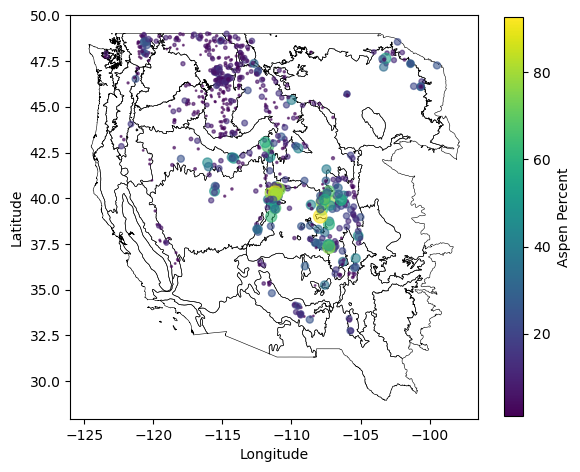

In [34]:
# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))
states = states.to_crs(4326)

ecol3 = ecol3.to_crs(4326)

# Generate centroids
centroid = props_gdf.copy()
centroid = centroid.to_crs(4326)
centroid['geometry'] = centroid.geometry.centroid
centroid['size'] = centroid['pct_cover'] * 10  # Adjust the scaling factor as necessary

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

ecol3.plot(ax=ax, edgecolor='black', linewidth=0.4, color='none')
centroid.plot(
    ax=ax, markersize=centroid['pct_cover'], 
    column='pct_cover', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid['pct_cover'].min(), vmax=centroid['pct_cover'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC.png'), dpi=300, bbox_inches='tight')

plt.show()

In [42]:
props_gdf_.columns

Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'geometry', 'pct_cover',
       'YEAR_NAME'],
      dtype='object')

In [45]:
# Plot the count of fires across US EPA Level III ecoregions
df = props_gdf_.groupby('na_l3name').agg(
    pct_cover_mean=('pct_cover', 'mean'),  # Mean percent cover
    fire_count=('pct_cover', 'count')      # Count of fires
).reset_index()
df

,na_l3name,pct_cover_mean,fire_count
0,Arizona/New Mexico Mountains,9.492362,40
1,Arizona/New Mexico Plateau,2.941475,1
2,Blue Mountains,3.688154,26
3,Canadian Rockies,7.118881,29
4,Cascades,8.086190,9
5,Central Basin and Range,11.075316,17
6,Coast Range,8.506429,1
7,Colorado Plateaus,14.962289,16
8,Columbia Mountains/Northern Rockies,6.115920,104
9,Columbia Plateau,3.318304,4


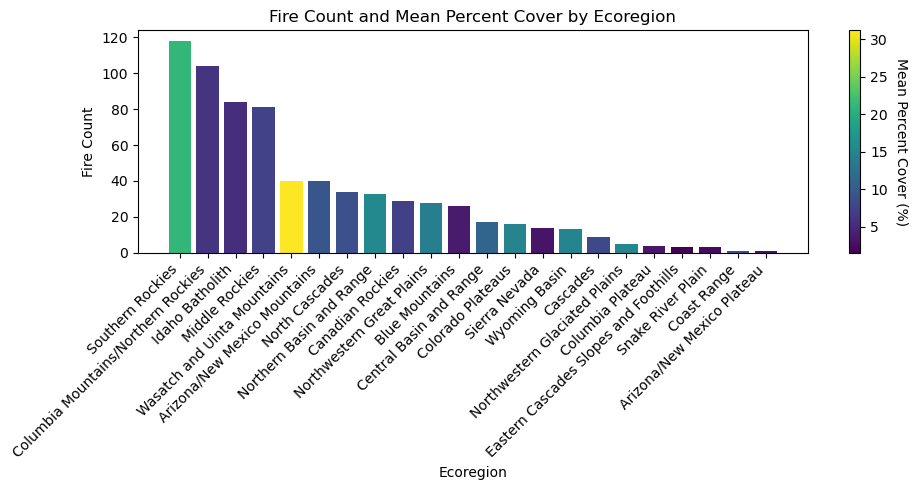

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df = df.sort_values('fire_count', ascending=False)

norm = plt.Normalize(df['pct_cover_mean'].min(), df['pct_cover_mean'].max())
cmap = cm.viridis  # Choose a colormap

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(
    df['na_l3name'], 
    df['fire_count'], 
    color=cmap(norm(df['pct_cover_mean']))
)

# Add colorbar for mean percent cover
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean Percent Cover (%)', rotation=270, labelpad=15)

# Add labels and title
ax.set_xlabel('Ecoregion')
ax.set_ylabel('Fire Count')
ax.set_title('Fire Count and Mean Percent Cover by Ecoregion')
ax.set_xticks(range(len(df['na_l3name'])))
ax.set_xticklabels(df['na_l3name'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [44]:
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

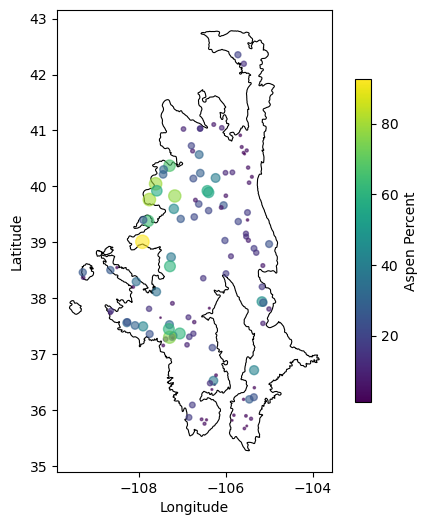

In [48]:
# Southern Rockies

centroid_srm = centroid[centroid['na_l3name'] == 'Southern Rockies']
ecol3_srm = ecol3[ecol3['na_l3name'] == 'Southern Rockies']

# plot it
fig, ax = plt.subplots(figsize=(6, 6))

ecol3_srm.plot(ax=ax, edgecolor='black', linewidth=0.8, color='none')
centroid_srm.plot(
    ax=ax, markersize=centroid_srm['pct_cover'], 
    column='pct_cover', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid_srm['pct_cover'].min(), vmax=centroid_srm['pct_cover'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC-SRM.png'), dpi=300, bbox_inches='tight')

plt.show()

In [41]:
gc.collect()

6504